In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

random.seed(42)

In [14]:
choices_slot_1 = ["weather", "similar_rentals", "advert"]
choices_slot_2 = ["weather", "advert", "instant_book"]
choices_slot_3 = ["instant_book", "advert"]

N = 20


s1 = random.choices(choices_slot_1, k=N)
s2 = random.choices(choices_slot_2, k=N)
s3 = random.choices(choices_slot_3, k=N)

def is_reward(s1, s2, s3):
    
    r = random.random()
    
    p = 0.2
    
    if s3 == 'instant_book':
        p = 0.4
        if s1 == 'similar_rentals':
            p = 0.7
    
    return 1 if r > p else -1
    

data = {'slot1': s1, 'slot2': s2, 'slot3': s3}

df = pd.DataFrame(data=data)
df['reward'] = df.apply(lambda x: is_reward(x['slot1'], x['slot2'], x['slot3']), axis=1)

display(df)

,slot1,slot2,slot3,reward
0,similar_rentals,weather,advert,1
1,weather,instant_book,advert,1
2,similar_rentals,instant_book,advert,1
3,advert,advert,advert,1
4,similar_rentals,weather,instant_book,-1
5,weather,advert,instant_book,-1
6,advert,weather,instant_book,1
7,similar_rentals,advert,advert,1
8,weather,advert,advert,1
9,weather,instant_book,advert,1


In [15]:
def feature_vector(slot1, slot2, slot3):
    s1 = choices_slot_1.index(slot1)
    s2 = choices_slot_2.index(slot2)
    s3 = choices_slot_3.index(slot3)
    
    sx1 = len(choices_slot_1)
    sx2 = len(choices_slot_2)
    sx3 = len(choices_slot_3)
    
    a = np.zeros(sx1 + sx2 + sx3)
    
    a[s1] = 1
    a[s2 + sx1] = 1
    a[s3 + sx1 + sx2] = 1
    return a
    
    
df['feature'] = df.apply(lambda x: feature_vector(x['slot1'], x['slot2'], x['slot3']), axis=1)

display(df)

,slot1,slot2,slot3,reward,feature
0,similar_rentals,weather,advert,1,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]"
1,weather,instant_book,advert,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
2,similar_rentals,instant_book,advert,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
3,advert,advert,advert,1,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
4,similar_rentals,weather,instant_book,-1,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
5,weather,advert,instant_book,-1,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
6,advert,weather,instant_book,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
7,similar_rentals,advert,advert,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
8,weather,advert,advert,1,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
9,weather,instant_book,advert,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"


In [93]:

from scipy.stats import norm, 

d = 8
t = 20

mu = np.zeros(d)
sigma = np.ones(d)

def v(t):
    return norm.pdf(t)

def w(t):
    return v(t) * (v(t) + t)

for i in range(t):
    row = df.iloc[i]
    feature = row['feature']
    reward = row['reward']
    
    beta = 1
    
    variance = beta**2 + feature*sigma
        
    mu = mu + reward * feature * sigma/variance * v(reward*feature*mu/sigma)
    sigma = sigma * (1 - feature * sigma/variance * w(reward * feature * mu/variance))
    
#     print('mu: {}'.format(mu))
#     print('sigma: {}'.format(sigma))

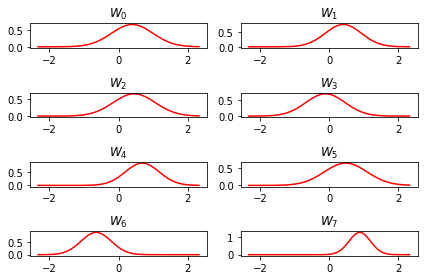

In [94]:
import matplotlib.pyplot as plt

for i in range(8):

    x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

    y = norm.pdf(x, loc=mu[i], scale=sigma[i])

    ax = plt.subplot(4, 2, i+1)
    ax.plot(x, y, 'r-', label=str(i))
    ax.set_title(r'$W_{}$'.format(i))


plt.tight_layout()
plt.show()

In [55]:
df

,slot1,slot2,slot3,reward,feature
0,similar_rentals,weather,advert,1,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]"
1,weather,instant_book,advert,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
2,similar_rentals,instant_book,advert,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
3,advert,advert,advert,1,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
4,similar_rentals,weather,instant_book,-1,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
5,weather,advert,instant_book,-1,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
6,advert,weather,instant_book,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
7,similar_rentals,advert,advert,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
8,weather,advert,advert,1,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
9,weather,instant_book,advert,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
